<a href="https://colab.research.google.com/github/loiswoo/Time-Series/blob/main/TS_study_w5_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **S & P 500 Stocks Prediction using Prophet**

TS_study_w3(final)에서 S & P 500 Stocks를 ARIMA, SARIMA를 이용하여 예측했습니다. 

같은 데이터셋을 Prophet을 이용하여 예측해보았습니다. 

https://hyperconnect.github.io/2020/03/09/prophet-package.html 

베이스 라인

https://zzsza.github.io/data/2019/02/06/prophet/

https://skyeong.net/290 

https://cordingdiary.tistory.com/109 


In [5]:
import sys
print(sys.version)

3.10.11 (main, Apr  5 2023, 14:15:10) [GCC 9.4.0]


In [1]:
!pip install prophet  # https://stackoverflow.com/questions/73142498/installing-fbprophet-on-colab

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [50]:
import prophet 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
pd.options.display.float_format = '{:.2f}'.format
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
import pickle


## 데이터 불러오기 및 전처리

In [25]:
df = pd.read_csv("/content/all_stocks_5yr.csv")

In [26]:
df.head()

,Date,Open,High,Low,Close,Volume,Name
0,2012-08-13,92.29,92.59,91.74,92.40,2075391.00,MMM
1,2012-08-14,92.36,92.50,92.01,92.30,1843476.00,MMM
2,2012-08-15,92.00,92.74,91.94,92.54,1983395.00,MMM
3,2012-08-16,92.75,93.87,92.21,93.74,3395145.00,MMM
4,2012-08-17,93.93,94.30,93.59,94.24,3069513.00,MMM


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 606801 entries, 0 to 606800
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Date    606801 non-null  object 
 1   Open    606417 non-null  float64
 2   High    606593 non-null  float64
 3   Low     606574 non-null  float64
 4   Close   606801 non-null  float64
 5   Volume  606395 non-null  float64
 6   Name    606801 non-null  object 
dtypes: float64(5), object(2)
memory usage: 32.4+ MB


In [28]:
df = df[df['Name'] == 'MMM'] #NAME = MMM인 종목만 사용 
                            #1258개의 dataset

In [29]:
df = df[500:] #최근 데이터만 반영하기 위하여 dataset 줄임

In [30]:
df.shape

(758, 7)

In [31]:
df.isnull().sum() #Close(종가)만 사용할 것이기 때문에 결측치 제거 x

Date      0
Open      1
High      0
Low       1
Close     0
Volume    0
Name      0
dtype: int64

In [32]:
df.info() #Date의 자료형이 object

<class 'pandas.core.frame.DataFrame'>
Int64Index: 758 entries, 500 to 1257
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    758 non-null    object 
 1   Open    757 non-null    float64
 2   High    758 non-null    float64
 3   Low     757 non-null    float64
 4   Close   758 non-null    float64
 5   Volume  758 non-null    float64
 6   Name    758 non-null    object 
dtypes: float64(5), object(2)
memory usage: 47.4+ KB


In [33]:
#Date 자료형 object ->  datetime
df['Date'] = pd.to_datetime(df.Date)

#df = df.set_index(df.Date) #prophet은 이전 모델과 달리 index 만들어주지 않고 ds과 y라는 컬럼으로 만들어줘야함
#df.drop('Date', axis = 1, inplace = True)

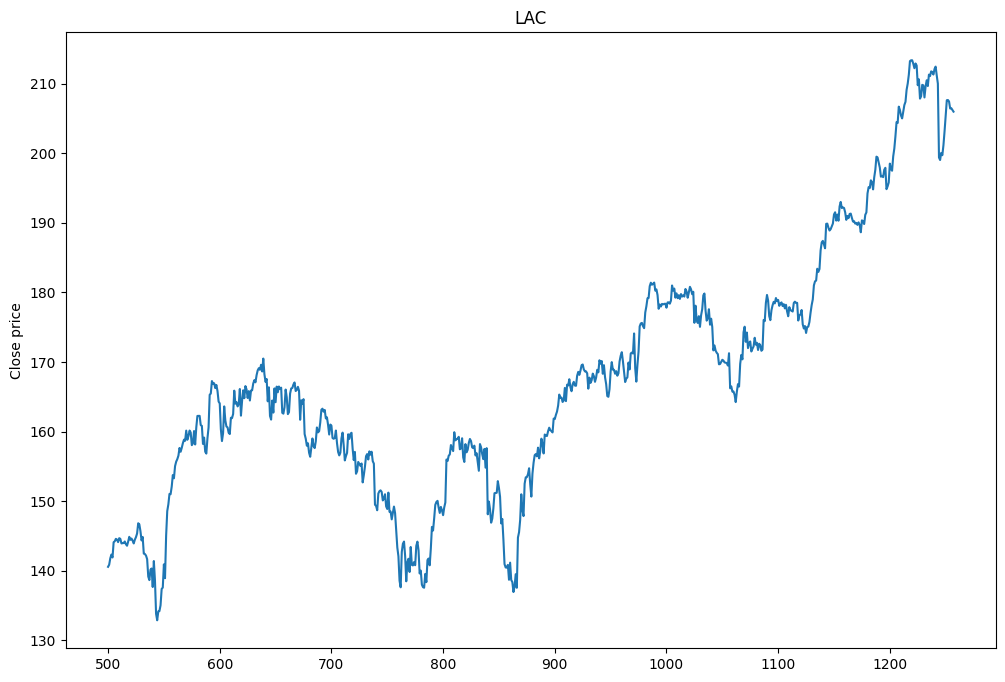

In [34]:
ax = df['Close'].plot(title = 'LAC', figsize = (12,8))
ax.set_ylabel('Close price')
plt.show()

필요없는 컬럼 삭제 및 ds, y 컬럼명 변경

In [35]:
df.head()

,Date,Open,High,Low,Close,Volume,Name
500,2014-08-11,140.93,141.50,140.54,140.58,1919082.00,MMM
501,2014-08-12,140.62,141.21,140.43,140.88,2176055.00,MMM
502,2014-08-13,141.35,141.83,140.92,141.80,3104251.00,MMM
503,2014-08-14,142.00,142.39,141.85,142.34,1586871.00,MMM
504,2014-08-15,142.81,142.98,141.02,141.92,1960967.00,MMM


In [36]:
df.drop('Open', axis = 1, inplace = True)
df.drop('High', axis = 1, inplace = True)
df.drop('Low', axis = 1, inplace = True)
df.drop('Volume', axis = 1, inplace = True)
df.drop('Name', axis = 1, inplace = True)

In [38]:
df.columns = ['ds', 'y']

In [39]:
df.head()

,ds,y
500,2014-08-11,140.58
501,2014-08-12,140.88
502,2014-08-13,141.80
503,2014-08-14,142.34
504,2014-08-15,141.92


In [40]:
#train:test = 8:2
#test: 365일
df_train = df[:606] #2014-08-11~2017-01-04
df_test = df[606:971] #2017-01-05~2018-08-11 아니고 2018~01-04

모델 생성

In [20]:
from prophet import Prophet

In [41]:
df_train.head()

,ds,y
500,2014-08-11,140.58
501,2014-08-12,140.88
502,2014-08-13,141.80
503,2014-08-14,142.34
504,2014-08-15,141.92


In [42]:
df_prophet = Prophet() #prophet object 생성
df_prophet.fit(df_train) #훈련 데이터를 피팅하여 prophet 모델 생성

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppi4rg_9p/lyf0rmiu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppi4rg_9p/07h5ilnr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11186', 'data', 'file=/tmp/tmppi4rg_9p/lyf0rmiu.json', 'init=/tmp/tmppi4rg_9p/07h5ilnr.json', 'output', 'file=/tmp/tmppi4rg_9p/prophet_modelt599fz8j/prophet_model-20230504060112.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:01:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:01:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


미래 예측 

In [45]:
fcast_time = 365
df_forecast = df_prophet.make_future_dataframe(periods = fcast_time, freq = 'D') #미래 dataframe 생성
df_forecast.tail(10)

,ds
961,2017-12-26
962,2017-12-27
963,2017-12-28
964,2017-12-29
965,2017-12-30
966,2017-12-31
967,2018-01-01
968,2018-01-02
969,2018-01-03
970,2018-01-04


In [46]:
#prophet 메서드를 이용한 주가 예측
df_forecast = df_prophet.predict(df_forecast)

In [47]:
#예측 결과 확인
df_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
966,2017-12-31,205.08,133.45,279.93
967,2018-01-01,201.05,128.32,277.09
968,2018-01-02,200.49,127.71,277.26
969,2018-01-03,200.06,127.46,277.60
970,2018-01-04,199.73,126.54,277.76


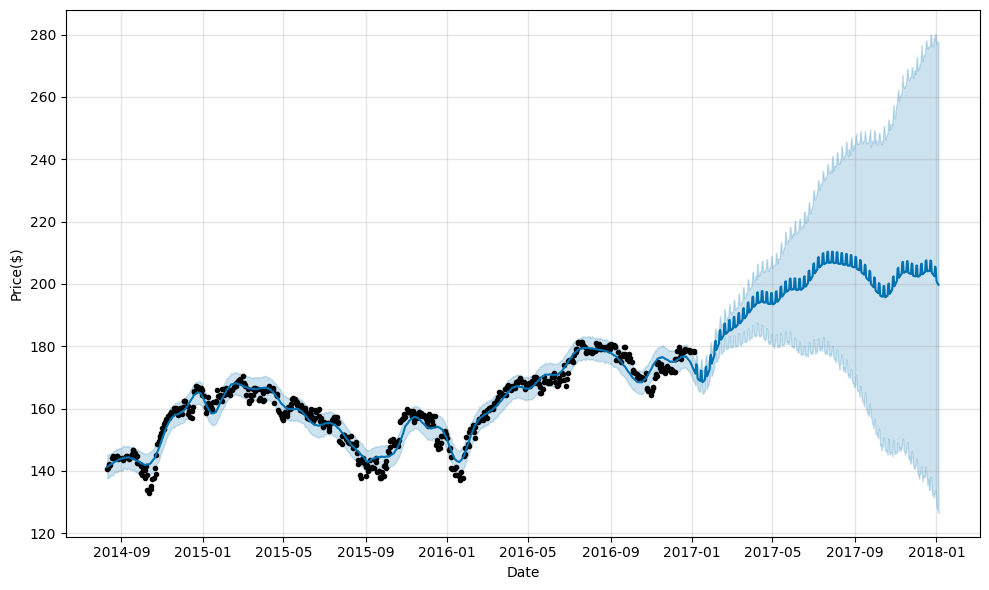

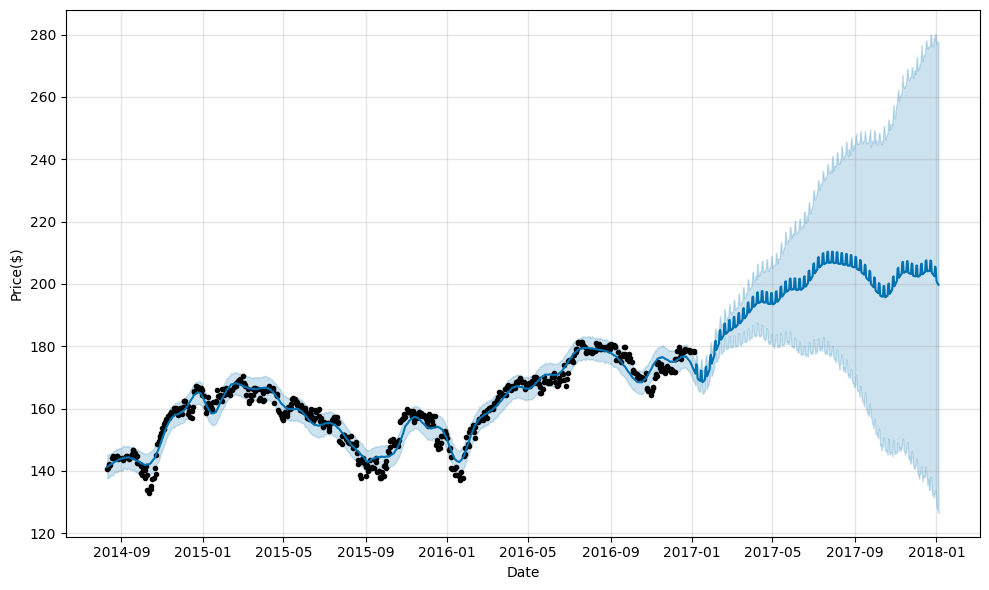

In [48]:
#예측값 시각화
df_prophet.plot(df_forecast, xlabel = 'Date', ylabel = 'Price($)')

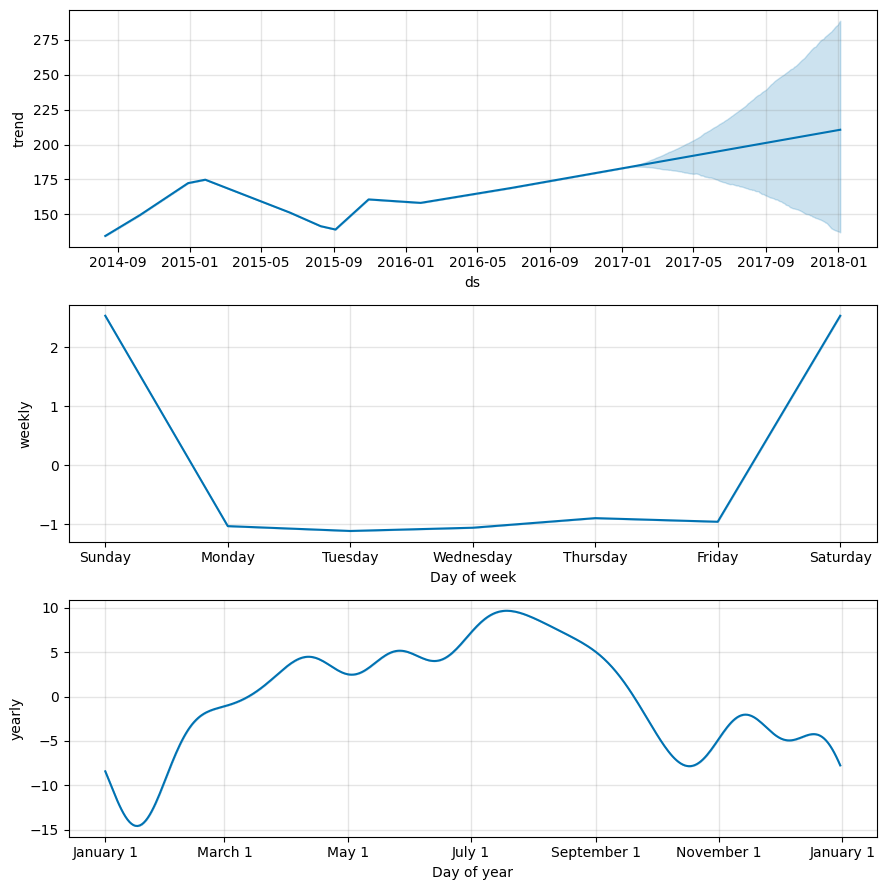

In [51]:
#예측 구성요소 확인(추세, 연간 계절성, 주간 계절성)
fig2 = df_prophet.plot_components(df_forecast)
plt.show()

## 교차 검증 분석

교차 검증 절차는 cross_validation 함수를 사용하여 과거 컷오프 범위에 대해 자동으로 수행된다. 예측 기간(horizon)을 지정한 다음 선택적으로 초기 훈련 기간(initial)의 크기와 컷오프 날짜 사이의 간격(period)을 지정한다. 

기본적으로 예측 기간(horizon)의 3배로 초기 훈련 기간(initial)이 설정되고, 컷오프 날짜(cutoff)는 수평선의 절반마다 이루어진다. 

In [54]:
from prophet.diagnostics import cross_validation
df_cv = cross_validation(df_prophet, initial ='600 days', period = '180 days' , horizon = '200 days')
df_cv.head()

INFO:prophet:Making 1 forecasts with cutoffs between 2016-06-18 00:00:00 and 2016-06-18 00:00:00


  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmppi4rg_9p/d0outusc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppi4rg_9p/yg_88ux0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4860', 'data', 'file=/tmp/tmppi4rg_9p/d0outusc.json', 'init=/tmp/tmppi4rg_9p/yg_88ux0.json', 'output', 'file=/tmp/tmppi4rg_9p/prophet_model_3pm36ph/prophet_model-20230504062010.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:20:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:20:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2016-06-20,169.75,166.71,172.92,171.23,2016-06-18
1,2016-06-21,169.75,166.32,173.06,171.37,2016-06-18
2,2016-06-22,169.90,166.62,172.96,171.23,2016-06-18
3,2016-06-23,170.11,166.85,173.47,174.11,2016-06-18
4,2016-06-24,170.19,167.07,173.49,169.12,2016-06-18


cross_validation의 출력은 각 시뮬레이션된 예측 날짜와 각 컷오프 날짜에 대해 실제 값(y)과 표본 외 예측 값(yhat)을 갖는 데이터 프레임이다. 

이 데이터 프레임은 yhat과 y값 사이의 오류를 측정하는데 사용할 수 있다. 

## 모형 성능 확인

In [55]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,19 days,10.67,3.27,2.86,0.02,0.02,0.02,0.54
1,20 days,13.56,3.68,3.23,0.02,0.02,0.02,0.46
2,23 days,17.44,4.18,3.67,0.02,0.02,0.02,0.38
3,24 days,22.94,4.79,4.22,0.02,0.03,0.02,0.31
4,25 days,27.40,5.23,4.58,0.03,0.03,0.03,0.31


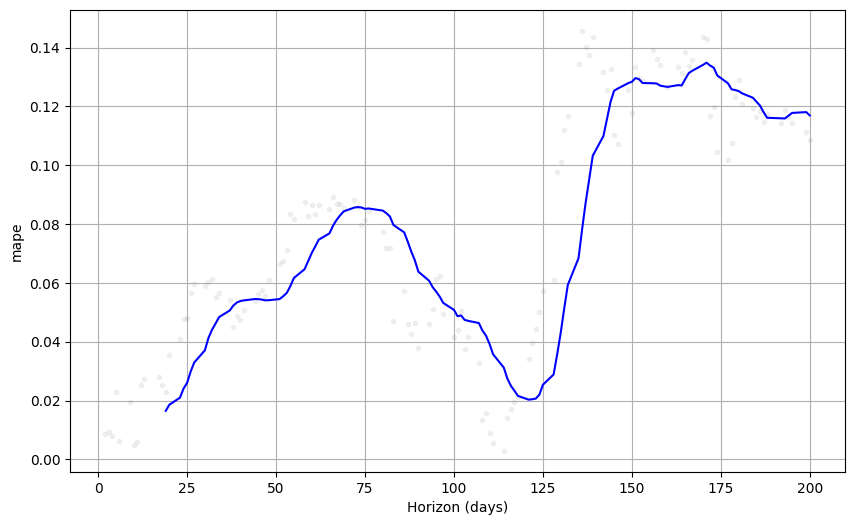

In [57]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric = 'mape')

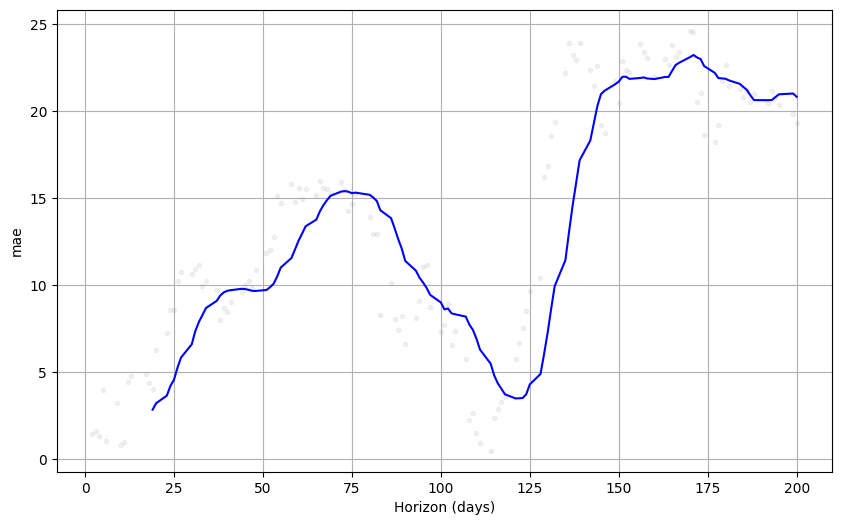

In [58]:
fig = plot_cross_validation_metric(df_cv, metric = 'mae')